# Imports

In [1]:
import h5py
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import matplotlib.ticker as tck
import numpy as np
import os
import pandas as pd
import seaborn as sns
import spacy

%matplotlib inline

### Helpers & Utilities

In [2]:
## Plotting Palette
# Create a dict object containing U.C. Berkeley official school colors for plot palette 
# reference : https://alumni.berkeley.edu/brand/color-palette

berkeley_palette = {'berkeley_blue'     : '#003262',
                    'california_gold'   : '#FDB515',
                    'metallic_gold'     : '#BC9B6A',
                    'founders_rock'     : '#2D637F',
                    'medalist'          : '#E09E19',
                    'bay_fog'           : '#C2B9A7',
                    'lawrence'          : '#00B0DA',
                    'sather_gate'       : '#B9D3B6',
                    'pacific'           : '#53626F',
                    'soybean'           : '#9DAD33',
                    'california_purple' : '#5C3160',
                    'south_hall'        : '#6C3302',
                    'wellman_tile'      : '#D9661F'}

## Pareto Plot utility

def pareto_plot(df, tot, x, y, x_label = None, y_label = None, title = None, show_pct_y = False, pct_format='{0:.0%}'):

    df = df.sort_values(y, ascending = False)
    x = df[x].values
    y = df[y].values

    fig = plt.figure(figsize=(10, 6), dpi = 100)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    ax1.bar(x = x, height = y, width = 0.9, align = 'center', edgecolor = berkeley_palette['berkeley_blue'],
        color = berkeley_palette['pacific'], linewidth = 1, alpha = 0.8)
    ax1.set_xticks(range(df.shape[0]))
    ax1.set_xticklabels(x, rotation = 45)
    ax1.get_yaxis().set_major_formatter(
        tck.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax1.tick_params(axis = 'y', labelsize = 8)
    ax1.tick_params(axis = 'y', labelcolor = berkeley_palette['pacific'])

    if x_label:
        ax1.set_xlabel(x_label, fontsize = 15, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
    if y_label:
        ax1.set_ylabel(y_label, fontsize = 15, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
    if title:
        plt.title(title, fontsize = 20, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

    weights = y / tot
    cumsum = weights.cumsum()

    ax2.plot(x, cumsum, color = berkeley_palette['south_hall'], label = 'Cumulative Distribution', alpha = 0.5)
    ax2.scatter(x, cumsum, color = berkeley_palette['california_purple'], marker = 'D', s = 5)
    ax2.set_ylabel('', color = berkeley_palette['berkeley_blue'])
    ax2.tick_params('y', colors = berkeley_palette['pacific'])
    ax2.set_ylim(0, 1.05)
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals], fontsize = 8)

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])

    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, xy = (x[i], cumsum[i] + .01), fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

    # Adjust the plot spine borders to be lighter
    for ax in [ax1, ax2]:
        for p, v in zip(["top", "bottom", "right", "left"], [0.0, 0.3, 0.0, 0.3]):
            ax.spines[p].set_alpha(v)

    # Sset the Y-axis grid-lines to dim, and display the Accuracy plot.
    plt.grid(axis='y', alpha=.3)
    plt.tight_layout()
    plt.show()

## <i>Load the (collected & pre-processed) data</i>

In [3]:
category_cols = ['abstract','acm_class','arxiv_id','author_text','categories',
                 'comments','created','doi','num_authors','num_categories','primary_cat',
                 'title','updated']

with h5py.File('processed_data/w299_categories.hdf5', 'r') as f:
    df = pd.DataFrame(np.array(f['arxiv_categories']), columns = category_cols)

df[['num_authors', 'num_categories']] = df[['num_authors', 'num_categories']].apply(pd.to_numeric)
df[['created','updated']] =df[['created', 'updated']].apply(pd.to_datetime)
df.head()

,abstract,acm_class,arxiv_id,author_text,categories,comments,created,doi,num_authors,num_categories,primary_cat,title,updated
0,Because of their occasional need to return to ...,nan,cs/9308101,M. L. Ginsberg,cs.AI,See http://www.jair.org/ for an online appendi...,1993-07-31,nan,1,1,cs.AI,Dynamic Backtracking,NaT
1,Market price systems constitute a well-underst...,nan,cs/9308102,M. P. Wellman,cs.AI,See http://www.jair.org/ for any accompanying ...,1993-07-31,nan,1,1,cs.AI,A Market-Oriented Programming Environment and ...,NaT
2,We describe an extensive study of search in GS...,nan,cs/9309101,"I. P. Gent, T. Walsh",cs.AI,See http://www.jair.org/ for any accompanying ...,1993-08-31,nan,2,1,cs.AI,An Empirical Analysis of Search in GSAT,NaT
3,As real logic programmers normally use cut (!)...,nan,cs/9311101,"F. Bergadano, D. Gunetti, U. Trinchero",cs.AI,See http://www.jair.org/ for any accompanying ...,1993-10-31,nan,3,1,cs.AI,The Difficulties of Learning Logic Programs wi...,NaT
4,To support the goal of allowing users to recor...,nan,cs/9311102,"J. C. Schlimmer, L. A. Hermens",cs.AI,See http://www.jair.org/ for an online appendi...,1993-10-31,nan,2,1,cs.AI,Software Agents: Completing Patterns and Const...,NaT


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103195 entries, 0 to 103194
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   abstract        103195 non-null  object        
 1   acm_class       103195 non-null  object        
 2   arxiv_id        103195 non-null  object        
 3   author_text     103195 non-null  object        
 4   categories      103195 non-null  object        
 5   comments        103195 non-null  object        
 6   created         103195 non-null  datetime64[ns]
 7   doi             103195 non-null  object        
 8   num_authors     103195 non-null  int64         
 9   num_categories  103195 non-null  int64         
 10  primary_cat     103195 non-null  object        
 11  title           103195 non-null  object        
 12  updated         39245 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(9)
memory usage: 10.2+ MB


## Minor data clean-up & organization

In [5]:
# one-hot encoding for categories
def identify_categories(cat, target_cat):
    return (target_cat in cat)

df['category_cs_AI'] = df.categories.apply(lambda x: identify_categories(x, 'cs.AI'))
df['category_cs_LG'] = df.categories.apply(lambda x: identify_categories(x, 'cs.LG'))
df['category_stat_ML'] = df.categories.apply(lambda x: identify_categories(x, 'stat.ML'))
df.drop(columns=['categories'], inplace = True)

## Analyze the data

In [6]:
len(df)

103195

In [7]:
# review count of papers by category (there are overlapping categories per paper)
cols = [c for c in df.columns if c.startswith('category')]
df[cols].sum()

category_cs_AI      32786
category_cs_LG      81463
category_stat_ML    65572
dtype: int64

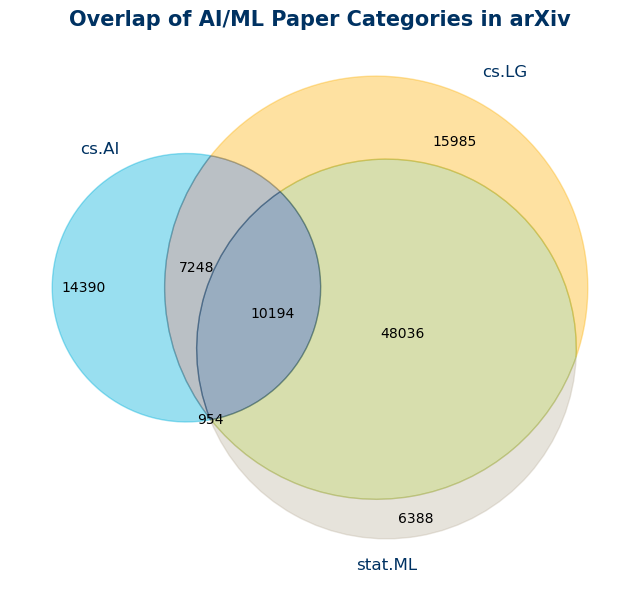

In [8]:
###########################################################################################################
## Create a 3-circle Venn Diagram of Category Overlap
###########################################################################################################

csAI = [i for i in df[(df.category_cs_AI == True)].index.values]
csLG = [i for i in df[(df.category_cs_LG == True)].index.values]
statML = [i for i in df[(df.category_stat_ML == True)].index.values]

## Generate the plot

fig = plt.figure(figsize=(8,8), dpi = 100)
ax = fig.add_subplot(111)

v = venn3([set(csAI), set(csLG), set(statML)], set_labels = ('cs.AI', 'cs.LG', 'stat.ML'))
# set the bubbles to Berkeley colors
for id, col in zip(['001', '010', '011', '100', '101', '111', 'A', 'B', 'C'],
        [berkeley_palette['bay_fog'], berkeley_palette['california_gold'], berkeley_palette['soybean'],
        berkeley_palette['lawrence'], berkeley_palette['pacific'], berkeley_palette['berkeley_blue'],
        berkeley_palette['lawrence'], berkeley_palette['california_gold'], berkeley_palette['pacific']]):
    x = v.get_patch_by_id(id)
    x.set_alpha(0.4)
    x.set_color(col)

# set the label colors to Berkeley blue
for id, col in zip(['A','B','C'], [berkeley_palette['berkeley_blue']] * 3):
    v.get_label_by_id(id).set_color(col)

ax.set_title('Overlap of AI/ML Paper Categories in arXiv', color = berkeley_palette['berkeley_blue'], fontsize = 15, fontweight = "bold")
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.3)

plt.show()


In [9]:
def go_bayes_or_go_home(P_A, P_B, P_B_given_A):
    return (P_B_given_A * P_A) / (P_B)

tot, df_joint_prob = df.shape[0], {}

df_joint_prob["P(cs.AI)"] = df[(df.category_cs_AI == True)].shape[0] / tot
df_joint_prob["P(cs.LG)"] = df[(df.category_cs_LG == True)].shape[0] / tot
df_joint_prob["P(stat.ML)"] = df[(df.category_stat_ML == True)].shape[0] / tot

df_joint_prob["P(cs.AI,cs.LG)"] = df[(df.category_cs_AI == True) & (df.category_cs_LG == True)].shape[0] / tot
df_joint_prob["P(cs.AI,stat.ML)"] = df[(df.category_cs_AI == True) & (df.category_stat_ML == True)].shape[0] / tot
df_joint_prob["P(cs.LG,stat.ML)"] = df[(df.category_cs_LG == True) & (df.category_stat_ML == True)].shape[0] / tot
df_joint_prob["P(cs.AI,cs.LG,stat.ML)"] = df[(df.category_cs_AI == True) & (df.category_stat_ML == True) & (df.category_cs_LG == True)].shape[0] / tot

df_joint_prob["P(cs.AI|cs.LG)"] = df[(df.category_cs_AI == True) & (df.category_cs_LG == True)].shape[0] / df[(df.category_cs_LG)].shape[0]
df_joint_prob["P(cs.LG|cs.AI)"] = go_bayes_or_go_home(P_A = df_joint_prob["P(cs.LG)"], P_B = df_joint_prob["P(cs.AI)"], P_B_given_A = df_joint_prob["P(cs.AI|cs.LG)"])

df_joint_prob["P(cs.AI|stat.ML)"] = df[(df.category_cs_AI == True) & (df.category_stat_ML == True)].shape[0] / df[(df.category_stat_ML)].shape[0]
df_joint_prob["P(stat.ML|cs.AI)"] = go_bayes_or_go_home(P_A = df_joint_prob["P(stat.ML)"], P_B = df_joint_prob["P(cs.AI)"], P_B_given_A = df_joint_prob["P(cs.AI|stat.ML)"])

df_joint_prob["P(cs.LG|stat.ML)"] = df[(df.category_cs_LG == True) & (df.category_stat_ML == True)].shape[0] / df[(df.category_stat_ML)].shape[0]
df_joint_prob["P(stat.ML|cs.LG)"] = go_bayes_or_go_home(P_A = df_joint_prob["P(stat.ML)"], P_B = df_joint_prob["P(cs.LG)"], P_B_given_A = df_joint_prob["P(cs.LG|stat.ML)"])

df_joint_prob["P(cs.AI|stat.ML,cs.LG)"] = df[(df.category_cs_AI == True) & (df.category_stat_ML == True) & (df.category_cs_LG == True)].shape[0] / df[(df.category_cs_LG == True) & (df.category_stat_ML == True)].shape[0]
df_joint_prob["P(cs.LG|stat.ML,cs.AI)"] = df[(df.category_cs_AI == True) & (df.category_stat_ML == True) & (df.category_cs_LG == True)].shape[0] / df[(df.category_cs_AI == True) & (df.category_stat_ML == True)].shape[0]
df_joint_prob["P(stat.ML|cs.LG,cs.AI)"] = df[(df.category_cs_AI == True) & (df.category_stat_ML == True) & (df.category_cs_LG == True)].shape[0] / df[(df.category_cs_LG == True) & (df.category_cs_AI == True)].shape[0]

df_joint_prob = pd.DataFrame(df_joint_prob, index = [0]).T
df_joint_prob[0] = df_joint_prob[0] * 100.
df_joint_prob.columns = ['probability']



#df_joint_prob.style.background_gradient(cmap = cm)

#df_joint_prob.style.bar(subset=['probability'], color = berkeley_palette['lawrence'])


# Test series

priors = df_joint_prob.loc[["P(cs.AI)","P(cs.LG)","P(stat.ML)"]].probability
intersects = df_joint_prob.loc[["P(cs.AI,cs.LG)", "P(cs.AI,stat.ML)", "P(cs.LG,stat.ML)", "P(cs.AI,cs.LG,stat.ML)"]].probability
joint_probs = df_joint_prob.loc[["P(cs.AI|cs.LG)", "P(cs.LG|cs.AI)", "P(cs.AI|stat.ML)", "P(stat.ML|cs.AI)", "P(cs.LG|stat.ML)", "P(stat.ML|cs.LG)", 
    "P(cs.AI|stat.ML,cs.LG)", "P(cs.LG|stat.ML,cs.AI)", "P(stat.ML|cs.LG,cs.AI)"]].probability

head = """
<table>
    <thead>
        <th></th>
        <th>Probabilities</th>
    </thead>
    </tbody>
"""

segments = zip(['Priors','Intersects','Joint Probs'], [priors, intersects, joint_probs], 
    [berkeley_palette['medalist'], berkeley_palette['pacific'], berkeley_palette['california_purple']])
for l, s, a in segments:
    row = f"<tr><th>{l}</th>"
    sc = s.copy()
    sc.name = ""
    #row += "<td>{}</td>".format(sc.to_frame().style.bar(align = a, color=['#d65f5f', '#5fba7d'], width = 100).render()) #testn['width']
    cm = sns.light_palette(a, as_cmap = True)
    row += "<td>{}</td>".format(sc.to_frame().style.background_gradient(cmap = cm).render())
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""


HTML(head)

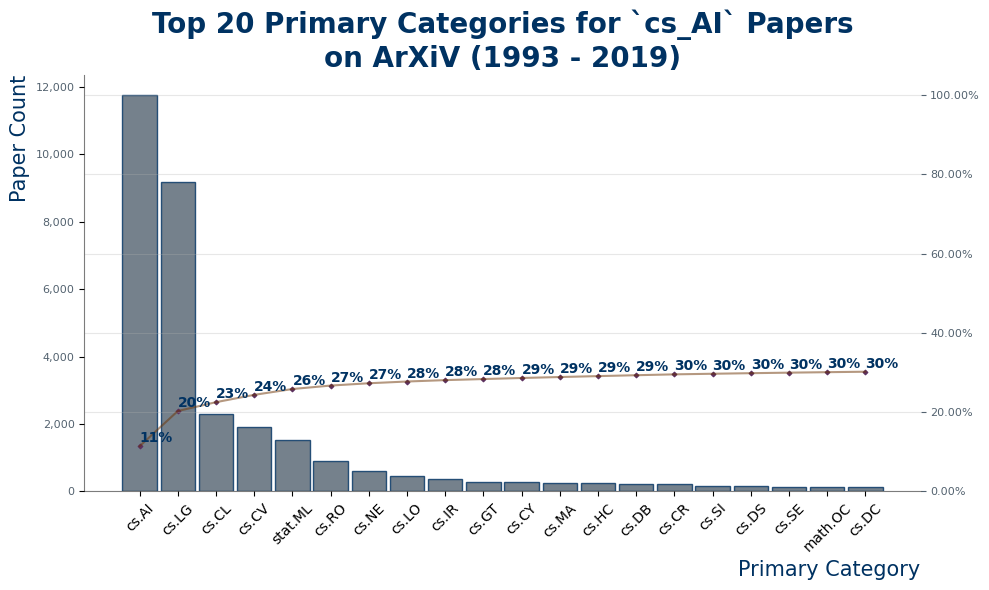

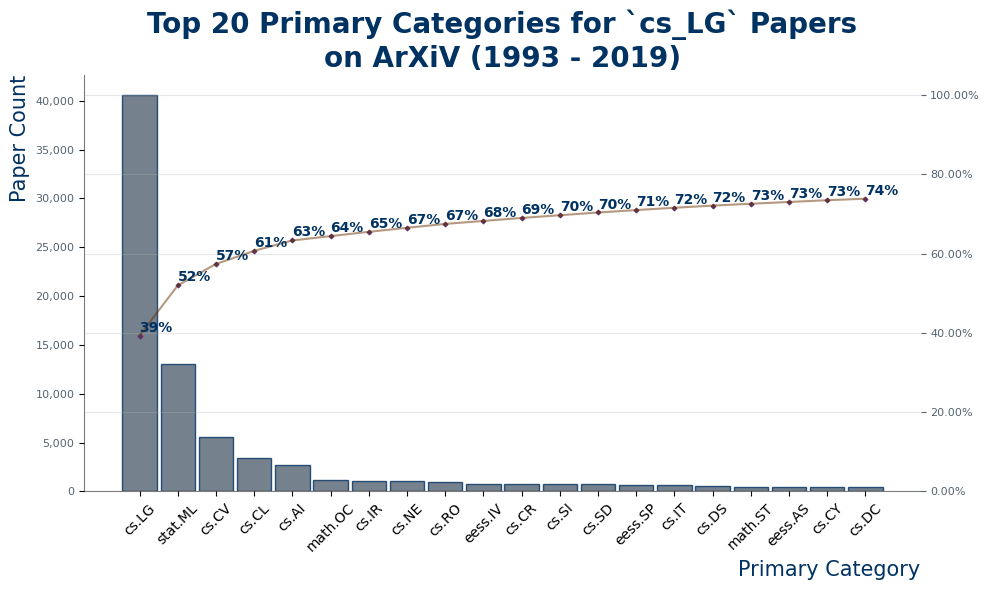

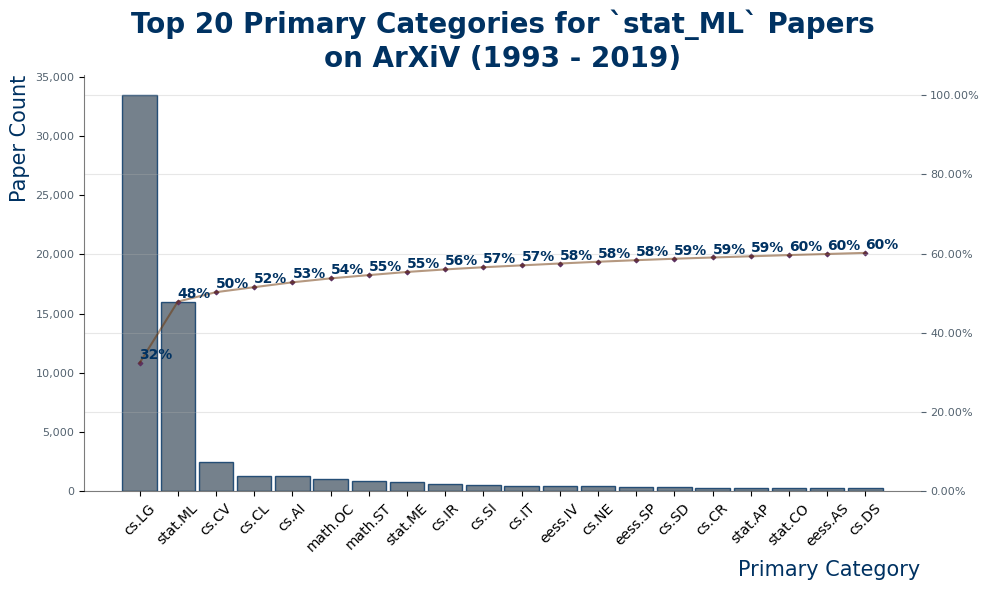

In [10]:
# evaluate what the Top 20 primary categories are for papers classified as `stat_ML`, `cs_AI`, and `cs_LG` on ArXiV from 1993 - 2019
df_categories = df.groupby(by=['primary_cat']).agg({'title': 'count', 'category_cs_AI': 'sum', 'category_cs_LG': 'sum', 'category_stat_ML': 'sum'}).astype(int)
df_categories.columns = ['total', 'cs_AI', 'cs_LG', 'stat_ML']

for c in ['cs_AI', 'cs_LG', 'stat_ML']:
    df_c = df_categories[c].sort_values(ascending = False).head(20).to_frame().reset_index()
    pareto_plot(df = df_c, tot = df_categories.total.sum(), x = 'primary_cat', y = c, 
        title = 'Top 20 Primary Categories for `%s` Papers\non ArXiV (1993 - 2019)' % (c), x_label = 'Primary Category', y_label = 'Paper Count', show_pct_y = True)

del df_categories, df_c

## Generate statistical columns for further analysis

In [22]:
# count the number of sentences per abstract using sentence detection with spaCy
# this takes a few minutes...
sp = spacy.load('en_core_web_lg')
def sentence_count(t):
    return len(list(sp(t.strip().lower()).sents))

df['abstract_sentence_count'] = df.abstract.apply(lambda x: sentence_count(x))

In [23]:
# capture word count in abstract (separted by spaces)
df['abstract_word_count'] = df.abstract.apply(lambda x: len(x.strip().split())) 
# capture number of unique words in abstract body
df['abstract_unique_word_count'] = df.abstract.apply(lambda x:len(set(str(x).split())))
# capture the word count in title
df['title_word_count'] = df.title.apply(lambda x: len(x.strip().split()))

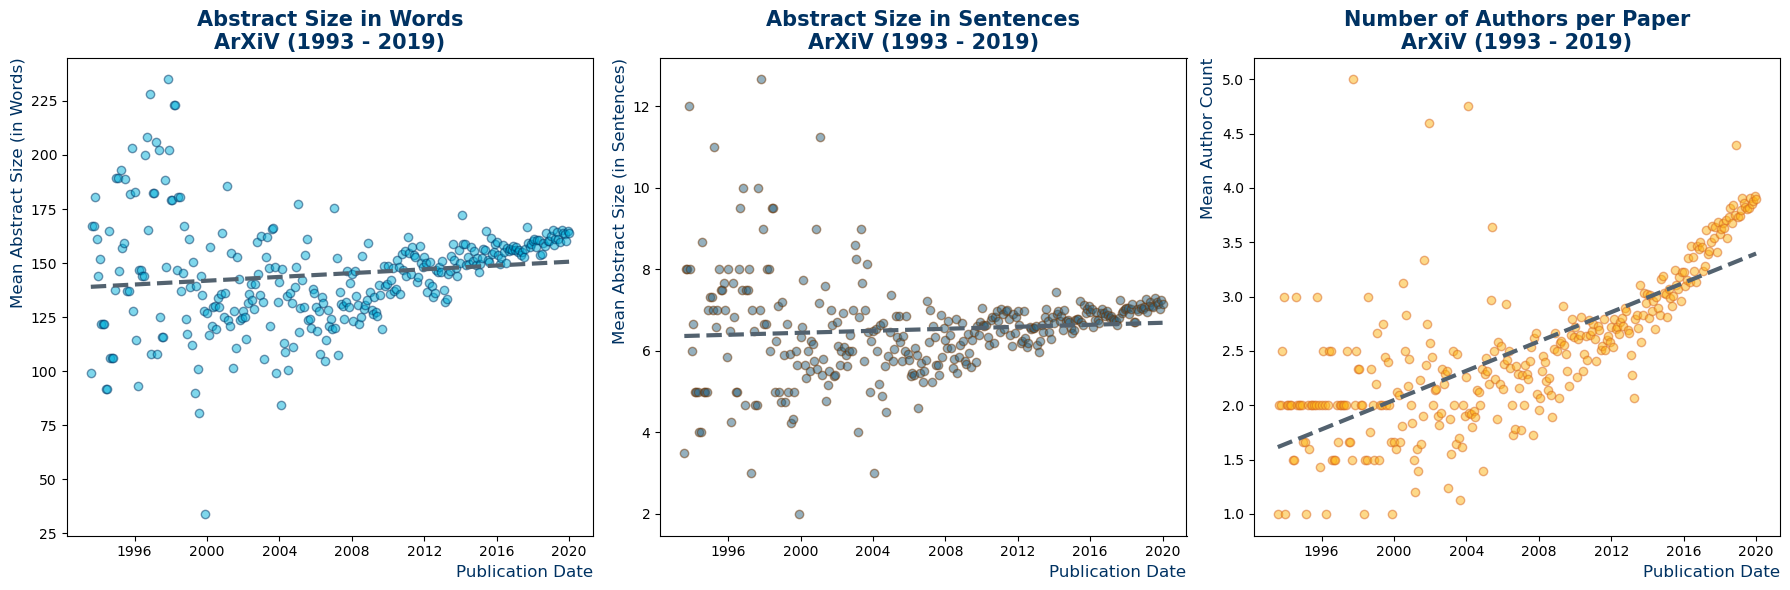

In [28]:

fig = plt.figure(figsize = (18, 6), dpi = 100)
ax = fig.add_subplot(131)

abs_data = df.groupby(pd.Grouper(key = 'created', freq = 'M')).abstract_word_count.mean().to_frame().ffill()
#ax.scatter(list(range(len(abs_data))), abs_data, color = berkeley_palette['berkeley_blue'])
ax.scatter(abs_data.index, abs_data, color = berkeley_palette['lawrence'], alpha = 0.5, edgecolor = berkeley_palette['berkeley_blue'])
m, b = np.polyfit(abs_data.index.astype(int), abs_data, 1)
ax.plot(abs_data.index, m*abs_data.index.astype(int) + b, color = berkeley_palette['pacific'], linestyle = '--', 
    alpha = 1, linewidth = 3)
ax.set_xlabel("Publication Date", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Mean Abstract Size (in Words)", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
plt.title("Abstract Size in Words\nArXiV (1993 - 2019)", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

ax = fig.add_subplot(132)

abs_data = df.groupby(pd.Grouper(key = 'created', freq = 'M')).abstract_sentence_count.mean().to_frame().ffill()
#ax.scatter(list(range(len(abs_data))), abs_data, color = berkeley_palette['berkeley_blue'])
ax.scatter(abs_data.index, abs_data, color = berkeley_palette['founders_rock'], alpha = 0.5, edgecolor = berkeley_palette['south_hall'])
m, b = np.polyfit(abs_data.index.astype(int), abs_data, 1)
ax.plot(abs_data.index, m*abs_data.index.astype(int) + b, color = berkeley_palette['pacific'], linestyle = '--', 
    alpha = 1, linewidth = 3)
ax.set_xlabel("Publication Date", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Mean Abstract Size (in Sentences)", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
plt.title("Abstract Size in Sentences\nArXiV (1993 - 2019)", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

ax1 = fig.add_subplot(133)
auth_data = df.groupby(pd.Grouper(key = 'created', freq = 'M')).num_authors.mean().to_frame().ffill()
ax1.scatter(auth_data.index, auth_data, color = berkeley_palette['california_gold'], alpha = 0.5, edgecolor = berkeley_palette['wellman_tile'])
m, b = np.polyfit(auth_data.index.astype(int), auth_data, 1)
ax1.plot(auth_data.index, m*auth_data.index.astype(int) + b, color = berkeley_palette['pacific'], linestyle = '--', 
    alpha = 1, linewidth = 3)
ax1.set_xlabel("Publication Date", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax1.set_ylabel("Mean Author Count", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
plt.title("Number of Authors per Paper\nArXiV (1993 - 2019)", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

plt.tight_layout()
plt.show()

## Stop words removal, digit removal, lemmatization, and other pre-processing of abstract text

Assumes you have already installed the ``en_core_web_lg`` language model:

```python
python -m spacy download en_core_web_lg
```

In [31]:
# create a "clean" version of the abstract for word-cloud visualization and perhaps topic modeling
def clean_text(t):
    clean_tokens = [token.lemma_ for token in sp(t) if token.is_alpha & (not token.is_stop) & (not token.is_space) & token.is_alpha]
    return " ".join(clean_tokens)

df['abstract_clean'] = df.abstract.apply(lambda x: clean_text(x.strip().lower()))

In [48]:
# Export Data for Analysis (Assignment #2)
df.drop(columns=['acm_class', 'arxiv_id', 'comments', 'doi', 'updated'], inplace = True)
fname = os.path.join(os.getcwd(), 'processed_data', 'assignment2.csv')
df.to_csv(fname, index = False, sep = ',', mode = 'w')
print(f"assignment #2 file '{fname}' written to disk.")


assignment #2 file 'c:\MIDS\W209 - Data Visualization\Repos\arxiv-ai-analysis\processed_data\assignment2.csv' written to disk.
